In [ ]:
j = 0
x = None
codes = []
return_mat = np.zeros((11602, 1271))
j = 0
for i in code_shares:
    price_matrix= sp_data[i].astype('float')
    price_matrix = np.array(price_matrix)
    returns = np.log(price_matrix[1:]) - np.log(price_matrix[0:-1])
    if np.where(returns<-5)[0].shape[0] == 0:
        codes.append(i)
        returns[np.isnan(returns)]=-5
        return_mat[:, j] = returns
        j += 1
df_return = pd.DataFrame(data=return_mat, columns=codes)
df_return.to_csv('returns127.csv')

In [179]:
import json
import mgarch
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt.blas import dot 
from cvxopt import solvers
solvers.options['show_progress'] = False




def load_json(path):
    with open(path, 'rb') as f:
        json_dict = json.load(f)
    return json_dict


def find_first_800(sp_data_matrix, num):
    posts = []
    trading_days = sp_data_matrix.shape[0]
    for i in range(trading_days):
        num_eff = np.sum(sp_data_matrix[i, 2:]>-5)
        if num_eff == num:
            posts.append(i)
    return posts[0]


def get_sub_mat(df_return, st_idx, code_shares, sp_data):
    indx_length = int(1260)
    num_lim = indx_length + 21
    ed_idx = st_idx + num_lim
    code_ls = list(df_return.columns)[1:]
    code_used = []
    res_mat = []
    res_dict = {}
    res_pre_dict = {}
    market_cap_dict = {}
    for code_i in code_ls:
        res = df_return[code_i][st_idx:ed_idx]
        eff_num = np.sum(res>-5)
        if eff_num == num_lim:
            cap_i = code_shares[code_i] * sp_data[code_i][st_idx+indx_length]
            res_ls  = list(res)
            res_mat.append(res_ls[0:indx_length])
            code_used.append(code_i)
            res_dict[code_i] = res_ls[0:indx_length]
            res_pre_dict[code_i] = res_ls[indx_length:indx_length+21]
            market_cap_dict[code_i] = cap_i
    return res_mat, code_used, res_dict, res_pre_dict, market_cap_dict


def get_N(res_mat, code_used, res_dict, res_pre_dict, market_cap_dict, N):
    line_num, row_num = np.where(np.corrcoef(np.array(res_mat))>0.95)
    line_num = line_num.tolist()
    row_num = row_num.tolist()
    code_used_ori = copy.deepcopy(code_used)
    code_used = set(code_used)
    for i in range(len(line_num)):
        for j in range(len(row_num)):
            if  i > j:
                stock_i = code_used_ori[line_num[i]]
                stock_j = code_used_ori[row_num[j]]
                cap_i = market_cap_dict[stock_i]
                cap_j = market_cap_dict[stock_j]
            
                if  cap_i>=cap_j and cap_i in code_used:
                    code_used.remove(stock_j)
                elif cap_i<cap_j and cap_i in code_used:
                    code_used.remove(stock_i)
    
    code_cap = {}   
    for code_i in code_used:
        code_cap[code_i] =  market_cap_dict[code_i]
        
    code_cap_sorted = sorted(code_cap.items(), key=lambda x: x[1], reverse=True)
    code_N = [i[0] for i in code_cap_sorted[0:N]]
    
    res_mat_new = []
    res_pre_new = []
    for code_i in code_N:
        res_mat_new.append(res_dict[code_i])
        res_pre_new.append(res_pre_dict[code_i])
    return res_mat_new, res_pre_new


def get_rolls(code_shares, sp_data, df_return, last_num, N, num):
    st_id = find_first_800(df_return.to_numpy(), num)
    roll_len = 1260+21
    j = 0
    all_rolls_res = 1
    while st_id+1260+21 <= last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                               st_id, code_shares, sp_data)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        res_mat_new = np.array(res_mat_new).transpose()
        res_pre_new = np.array(res_pre_new).transpose()
        res_all = np.vstack((res_mat_new, res_pre_new))
        st_id += 21
        if all_rolls_res is  1:
            all_rolls_res = res_all
        else:
            all_rolls_res = np.vstack((all_rolls_res, res_all))
        
    return all_rolls_res


def get_return(weights, res_pre):
    weights = np.matrix(weights)
    res_pre = np.matrix(res_pre)
    return (weights*res_pre).tolist()[0]
    

def average_weights(n):
    return np.matrix([1/n for i in range(n)])


def sample_cov_weights(res_mat):
    cov = np.cov(np.array(res_mat))
    N = cov.shape[0]
    P = matrix(cov)
    q = matrix(np.zeros((N, 1)))
    G  = matrix(-np.identity(N))
    h = matrix(np.zeros((N, 1)))
    A = matrix(1.0, (1, N))
    b = matrix(1.0)
    sol = solvers.qp(P, q, G, h, A, b)
    ws = np.matrix(sol['x']).T
    return ws

def predict_vol_dcc(res):
    vol = mgarch.mgarch()
    st = time.time()
    vol.fit(res)
    ed = time.time()
    print(ed-st)
    cov = 0
    for day_i in range(21):
        cov_nextday = vol.predict(day_i, )
        cov += cov_nextday['cov']
    cov = cov / 21
    return cov


def get_returns(code_shares, sp_data, df_return, last_num, N, num):
    st_id = find_first_800(df_return.to_numpy(), num)
    res_ew = []
    res_sample_cov = []
    while st_id + 1260+21 <= last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                                st_id, code_shares, sp_data)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        st_id += 21
        avg_ws = average_weights(N)
        avg_res_i = get_return(avg_ws, res_pre_new)
        res_ew += avg_res_i
        samp_ws = sample_cov_weights(res_mat_new)
        sam_res_i = get_return(samp_ws,  res_pre_new)
        res_sample_cov += sam_res_i
    return res_ew, res_sample_cov





def get_returns_dcc(code_shares, sp_data, df_return, last_num, N, num):
    st_id = find_first_800(df_return.to_numpy(), num)
    res_ew = []
    res_dcc_cov = []
    while st_id + 1260+21 <= last_num:
        res_mat, code_used, res_dict, res_pre_dict, market_cap_dict = get_sub_mat(df_return,
                                                                st_id, code_shares, sp_data)
        res_mat_new, res_pre_new = get_N(res_mat, code_used, 
                               res_dict, res_pre_dict, market_cap_dict, N)
        dcc_ws = predict_vol_dcc(res_mat_new)
        dcc_res_i = get_return(dcc_ws,  res_pre_new)
        res_dcc_cov += dcc_res_i
    return res_dcc_cov

# 1 load_data and get return rates

In [4]:
code_shares = load_json('./code_shares.json')
sp_data = pd.read_csv('./SP1273_19750103_20201231.csv')
df_return = pd.read_csv('./returns1271.csv')

# 2 get all rolling res data

In [ ]:
all_rolls_res = get_rolls(code_shares, sp_data, df_return, 11602, 500, 800)
np.savetxt("roll_res.csv", all_rolls_res, delimiter=",")

In [ ]:
all_rolls_res1 = np.around(all_rolls_res, decimals=6, out=None)
col_names = []
for i in range(500):
    col_names.append('asset{}'.format(i))
df_rolls = pd.DataFrame(data=all_rolls_res1, columns=col_names)
df_rolls.to_csv('df_rolls.csv')

# 3 get portfolio universe

In [180]:
avg_res, samp_res = get_returns(code_shares, sp_data, df_return, 11602, 500, 800)

In [181]:
AV_avg = np.mean(avg_res)*252*100
SD_avg = np.cov(avg_res)**0.5*252**0.5*100
IR_avg = AV_avg/SD_avg

AV_sam = np.mean(samp_res)*252*100
SD_sam = np.cov(samp_res)**0.5*252**0.5*100
IR_sam = AV_sam/SD_sam


print('|', round(AV_avg, 4), '|', round(SD_avg, 4), '|' , round(IR_avg, 4), '|')
print('|', round(AV_sam, 4), '|', round(SD_sam, 4), '|' , round(IR_sam, 4), '|')


| 6.8272 | 21.9555 | 0.311 |
| 5.6747 | 13.0984 | 0.4332 |


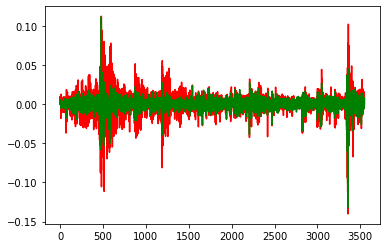

In [126]:
plt.plot(avg_res, c='r')
plt.plot(samp_res, c='g')
plt.show()